## Imports

In [1]:
# Enable automatic extension autoreloading
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch

import datasets
from datasets import load_dataset
# Don't show progress datasets bars
datasets.disable_progress_bar()

import sys
sys.path.insert(0, str(Path.cwd().parent.resolve()))
from dataset import get_dataset, collator
from model import get_model
from reward_model import get_reward_model, get_probe, create_reward_fn
from utils import get_tokenizer

ELK_PATH = Path("/fsx/home-augustas/elk/")
modules = [
    ELK_PATH,
    ELK_PATH / "elk" / "promptsource",
]
for module in modules:
    if not str(module) in sys.path:
        sys.path.insert(0, str(module.resolve()))

print(sys.path[:2])

from templates import DatasetTemplates

['/fsx/home-augustas/elk/elk/promptsource', '/fsx/home-augustas/elk']


## Config

In [3]:
device = torch.device(
    f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"
)
device

device(type='cuda', index=0)

In [4]:
tokenizer_name = "gpt2-xl"

# dataset_name = "AugustasM/burns-datasets-VINC-ppo-training-v4"
# reward_model_output_path = "/fsx/home-augustas/logs/unifiedqa-v2-t5-3b-1363200_custom_data_v4_all_20230629_120158_21789"

dataset_name = "AugustasM/burns-datasets-VINC-imdb-ppo-training-v2"
# reward_model_output_path = "/fsx/home-augustas/logs/unifiedqa-v2-t5-3b-1363200_custom_data_imdb_v2_first_20230707_170052_28991"
reward_model_output_path = "/fsx/home-augustas/logs/UQA-3b-custom_data_imdb_v2_final_20230717_200713_36998"

In [5]:
# probe, layer = get_probe(
#     Path(reward_model_output_path), current_device=device,
#     supervised=True, is_bf16_possible=True,
# )

# if hasattr(probe, "parameters"):
#     print([p.dtype for p in probe.parameters()])

# x = torch.randn(64, 1024, device=device).bfloat16()
# with torch.no_grad():
#     y = probe(x)

# y.shape, y.dtype

## Load things in

In [6]:
# Tokenizer
tokenizer = get_tokenizer(tokenizer_name)

Loading tokenizer gpt2-xl...


Using pad_token, but it is not set yet.


Loaded tokenizer.



In [7]:
# Dataset for PPO training
train_dataset, prompt_max_len, response_max_len = get_dataset(
    dataset_name, tokenizer, subsets_to_delete=["piqa"]
)

# Dataset templates
dataset_template_path = "AugustasM/burns-datasets-VINC/first"
dataset_templates = DatasetTemplates(dataset_template_path)
dataset_templates.templates = {
    x.name: x for x in dataset_templates.templates.values()
}
print(f"Num templates: {len(dataset_templates.templates)}")
template = list(dataset_templates.templates.values())[0]

Loading dataset...



Found cached dataset parquet (/admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-4d0b8014b84c4f24.arrow


Deleting subset: piqa


Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-e780a8c18648288e_*_of_00012.arrow
Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-8853ee18a1cb95fd_*_of_00012.arrow
Loading cached shuffled indices for dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-imdb-ppo-training-v2-7a8c35d13838a0fc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-4f7a08da32ccfe27.arrow



Max prompt length: 613

Max response length: 1

Remaining columns: ['prompt', 'best_response', 'input_ids', 'attention_mask', 'response_len']

Total number of examples: 8192

Processing finished.

Num templates: 1


In [8]:
torch.randn(1).to(device)

tensor([-0.4387], device='cuda:0')

In [9]:
rm_batch_size = 64

# Get the reward model
reward_model, reward_model_name = get_reward_model(
    reward_model_output_path, device,
    supervised=True,
)
reward_model_tokenizer = get_tokenizer(reward_model_name)

# Create reward function
get_rewards = create_reward_fn(
    reward_model=reward_model,
    reward_model_tokenizer=reward_model_tokenizer,
    rm_batch_size=rm_batch_size,
    template=template,
    device=device,
)

The current device is cuda:0.

Loading reward model from allenai/unifiedqa-v2-t5-3b-1363200.
is_bf16_possible=True


Loaded reward model with 2,851,598,336 parameters.
Number of trainable params 0 parameters.
Reward model dtype: torch.bfloat16

layer=13
Loading the probe from /fsx/home-augustas/VINC-logs/allenai/unifiedqa-v2-t5-3b-1363200/AugustasM/burns-datasets-VINC-imdb-v2/silly-leavitt/lr_models/layer_13.pt
Loaded the probe.

Loading tokenizer allenai/unifiedqa-v2-t5-3b-1363200...
Falling back to slow tokenizer; fast one failed: 'No such file or directory (os error 2)'
Loaded tokenizer.



In [10]:
dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

rewards = []

for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    texts = [q + r for q, r in zip(batch["prompt"], batch["best_response"])]

    current_rewards = get_rewards(texts)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
rewards.shape

Dataloader length: 256


  0%|          | 0/256 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


torch.Size([8192])

In [11]:
mean = rewards.mean()
std = rewards.std()

mean, std

(tensor(0.9437), tensor(0.1532))

In [12]:
mean - 2 * std, mean + 2 * std

(tensor(0.6373), tensor(1.2502))

In [13]:
rewards.min(), rewards.max()

(tensor(0.0043), tensor(1.))

In [20]:
def plot_histogram(rewards, bins=100, color="blue", secondary_color="red", alpha=1, xlim=None):
    if xlim is None:
        xlim = [0, 1]

    mean = rewards.mean()
    std = rewards.std()

    # Histogram of rewards with black borders
    plt.hist(rewards, bins=bins, edgecolor="black", color=color, alpha=alpha);

    # Plot vertical lines for mean +- std
    plt.axvline(mean, color=secondary_color, label=f"{mean=:.4f}")
    plt.axvline(mean + 2 * std, color=secondary_color, linestyle="--", label=f"upper={mean + 2 * std:.4f}")
    plt.axvline(mean - 2 * std, color=secondary_color, linestyle="--", label=f"lower={mean - 2 * std:.4f}");

    # Set xlim to 0-1
    plt.xlim(xlim)

    # Legend
    plt.legend()

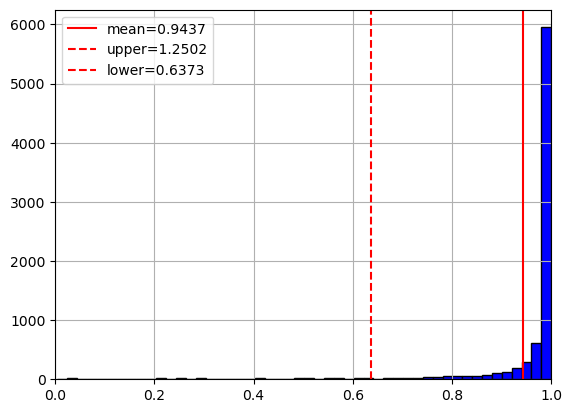

In [15]:
plot_histogram(rewards, bins=50)
plt.grid();

In [16]:
# plot_histogram(rewards[rewards >= 0.99975].float(), bins=50, xlim=(0.99975, 1.0))
# plt.grid();

In [21]:
# Save the rewards
# torch.save(rewards, "outputs/ppo_rewards_imdb_supervised_perfect.pt")

In [18]:
# tmp_rewards = torch.load("outputs/ppo_rewards_imdb_perfect.pt")
# tmp_rewards.dtype

## Get rewards for the base model

In [10]:
# Model
model_name = "gpt2-xl"
model = get_model(model_name, device)

Loading policy model...

is_bf16_possible=True


Loaded subject model with 1,557,612,801 parameters.
Model dtype: torch.bfloat16



In [39]:
from trl import PPOTrainer, PPOConfig

config = PPOConfig()

optimizer = None

# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model=None,
    tokenizer=tokenizer,
    dataset=train_dataset,
    data_collator=collator,
    optimizer=optimizer,
)

In [40]:
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

generation_kwargs = {
    "top_k": 0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": 100_000, # why is this value like this?
    "pad_to_multiple_of": 8, # TODO: double-check, but this seems to work and to be faster
}

rewards = []
max_new_tokens_list = []
for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    question_tensors = batch["input_ids"]

    max_new_tokens = max(batch["response_len"])
    max_new_tokens = max(4, max_new_tokens)
    max_new_tokens_list.append(max_new_tokens)
    generation_kwargs["max_new_tokens"] = max_new_tokens

    response_tensors = ppo_trainer.generate(
        question_tensors,
        return_prompt=False,
        # length_sampler=output_length_sampler, # TODO: can be none
        batch_size=4, # TODO: generations are made in batches
        **generation_kwargs,
    )
    batch["response"] = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

    # Compute sentiment score
    texts = [q + r for q, r in zip(batch["prompt"], batch["response"])]
    current_rewards = get_rewards(texts)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
rewards.shape

Dataloader length: 512


  0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([8192])

In [41]:
set(max_new_tokens_list)

{4}

In [43]:
rewards.min(), rewards.max()

(tensor(3.7636e-05), tensor(1.))

In [44]:
rewards.mean(), rewards.std()

(tensor(0.8296), tensor(0.2777))

In [45]:
rewards.mean() - rewards.std(), rewards.mean() + rewards.std()

(tensor(0.5519), tensor(1.1072))

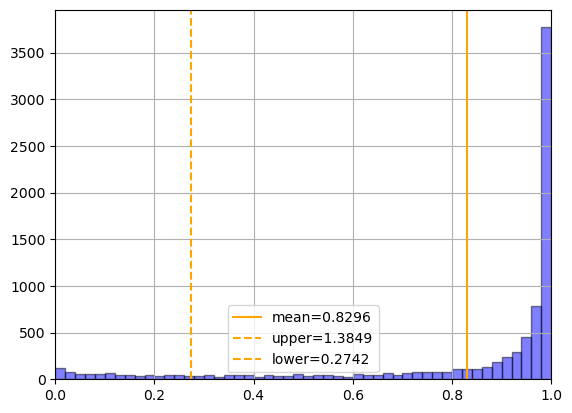

In [47]:
bins = 50
plot_histogram(rewards, bins=bins, color="blue", secondary_color="orange", alpha=0.5)
# Grid
plt.grid()

In [50]:
# Save the rewards
# torch.save(rewards, "outputs/ppo_rewards_imdb_supervised_len_4.pt")

tensor(0.9846)


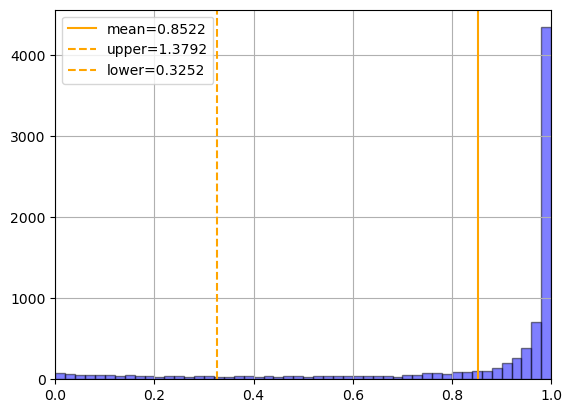

In [54]:
tmp_rewards = torch.load("outputs/ppo_rewards_imdb_supervised_len_1.pt")
print(tmp_rewards.median())
bins = 50
plot_histogram(tmp_rewards, bins=bins, color="blue", secondary_color="orange", alpha=0.5)
# Grid
plt.grid()